In [1]:
dfContestacoes = sqlContext.read.parquet("hdfs:/user/x181471/cache-hive/transacoes/credito/final/contestadas")

In [2]:
dfContestacoes.cache()

DataFrame[idSia: string, cartao: string, dataHoraAutorizacao: timestamp, idEstabelecimento: string, nomeEstabelecimento: string, ramoEstabelecimentoId: bigint, ramoEstabelecimentoNome: string, modoEntradaId: string, modoEntradaNome: string, pais: bigint, tipoLancamento: bigint, flagContestacao: boolean, valor: double, contcur: timestamp, observacoes: string]

In [3]:
dfContestacoes.count()

14333

**Verificar se existem contestações que não encontramos a autorização correspondente:**

É preciso comparar o número de transações com idSia distintos encontrados antes e depois do join com a MPDT004 (Autorizações):

In [4]:
dfContestacoes.select('idSia').distinct().count()

14333

In [5]:
dfContestacoesAntesDoJoin = sqlContext.read.parquet("hdfs:/user/x181471/cache-hive/contestacoes/credito/final")

In [6]:
dfContestacoesAntesDoJoin.filter('flagContestacao = true').select('idSia').distinct().count()

22179

##### Realizando os principais imports

In [7]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when, mean, min, max, desc, to_date, col, year

##### Verificando a estatística básica do dado:

In [8]:
dfContestacoes.describe().show()

+-------+---------------------+------------------+-----------------+------------------+
|summary|ramoEstabelecimentoId|              pais|   tipoLancamento|             valor|
+-------+---------------------+------------------+-----------------+------------------+
|  count|                14333|             14333|            14333|             14333|
|   mean|    5781.797809251378| 252.0174422660992|6088.815809669993|348.97677178539163|
| stddev|    1389.257397151853|300.64069955132476| 37.8186669374842|1060.7382393461621|
|    min|                 1520|                32|             6000|              0.02|
|    max|                 9405|               858|             6521|          28687.82|
+-------+---------------------+------------------+-----------------+------------------+



In [9]:
dfContestacoes.show(5,False)

+----------------+----------------+---------------------+-----------------+-------------------+---------------------+-----------------------+-------------+---------------+----+--------------+---------------+-----+--------------------------+-----------+
|idSia           |cartao          |dataHoraAutorizacao  |idEstabelecimento|nomeEstabelecimento|ramoEstabelecimentoId|ramoEstabelecimentoNome|modoEntradaId|modoEntradaNome|pais|tipoLancamento|flagContestacao|valor|contcur                   |observacoes|
+----------------+----------------+---------------------+-----------------+-------------------+---------------------+-----------------------+-------------+---------------+----+--------------+---------------+-----+--------------------------+-----------+
|1015136131596350|4916746863296037|2016-04-07 02:29:12.0|010379630480001  |COMPRAEVOLTABR.    |7278                 |SERVIÇOS               |01           |Digitada       |76  |6100          |true           |20.9 |2016-04-09 00:02:42.614617| 

Verificando a data minima e máxima dos dados de contestação:

In [10]:
dfContestacoes.select([min('dataHoraAutorizacao'),max('dataHoraAutorizacao'),mean('valor'),min('valor'), max('valor')]).show(25,False)

+------------------------+------------------------+------------------+----------+----------+
|min(dataHoraAutorizacao)|max(dataHoraAutorizacao)|avg(valor)        |min(valor)|max(valor)|
+------------------------+------------------------+------------------+----------+----------+
|2015-07-17 22:39:52.0   |2016-07-26 22:46:15.0   |348.97677178539226|0.02      |28687.82  |
+------------------------+------------------------+------------------+----------+----------+



In [11]:
dfContestacoes.show

<bound method DataFrame.show of DataFrame[idSia: string, cartao: string, dataHoraAutorizacao: timestamp, idEstabelecimento: string, nomeEstabelecimento: string, ramoEstabelecimentoId: bigint, ramoEstabelecimentoNome: string, modoEntradaId: string, modoEntradaNome: string, pais: bigint, tipoLancamento: bigint, flagContestacao: boolean, valor: double, contcur: timestamp, observacoes: string]>

## Avaliando a distribuição de contestações pelo modo entrada e país

Preperando os dados para os gráficos com novas colunas

In [12]:
dfContestacoesModoEntrada = dfContestacoes.withColumn('usoPresente',
                                                      when(dfContestacoes.modoEntradaNome == "Tarja","Presente").
                                                      when(dfContestacoes.modoEntradaNome == "Chip","Presente").
                                                      otherwise("Não Presente"))

Analisando o ramo do estabelecimento vs o tipo de uso (Presente x Não Presente):

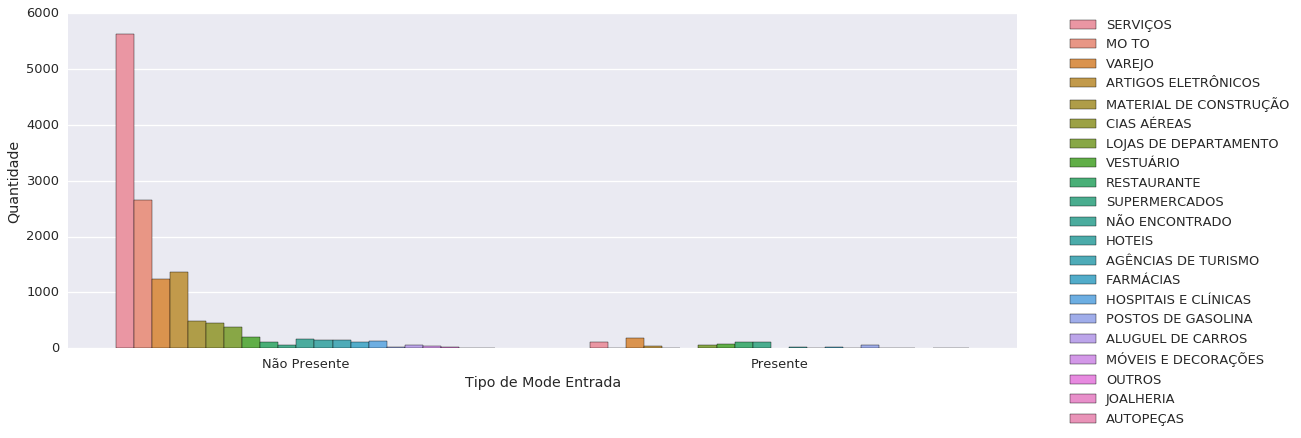

In [13]:
from pyspark.sql.functions import desc
sns.set_context("talk")
plt.figure(figsize=(17, 6))

contestacoesPorRamoEUsoPandas = dfContestacoesModoEntrada.cube("ramoEstabelecimentoNome", "usoPresente").count().orderBy("usoPresente",desc("count")).toPandas()
g = sns.barplot(x="usoPresente", y="count", hue="ramoEstabelecimentoNome", data=contestacoesPorRamoEUsoPandas)
g.set(xlabel='Tipo de Mode Entrada', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

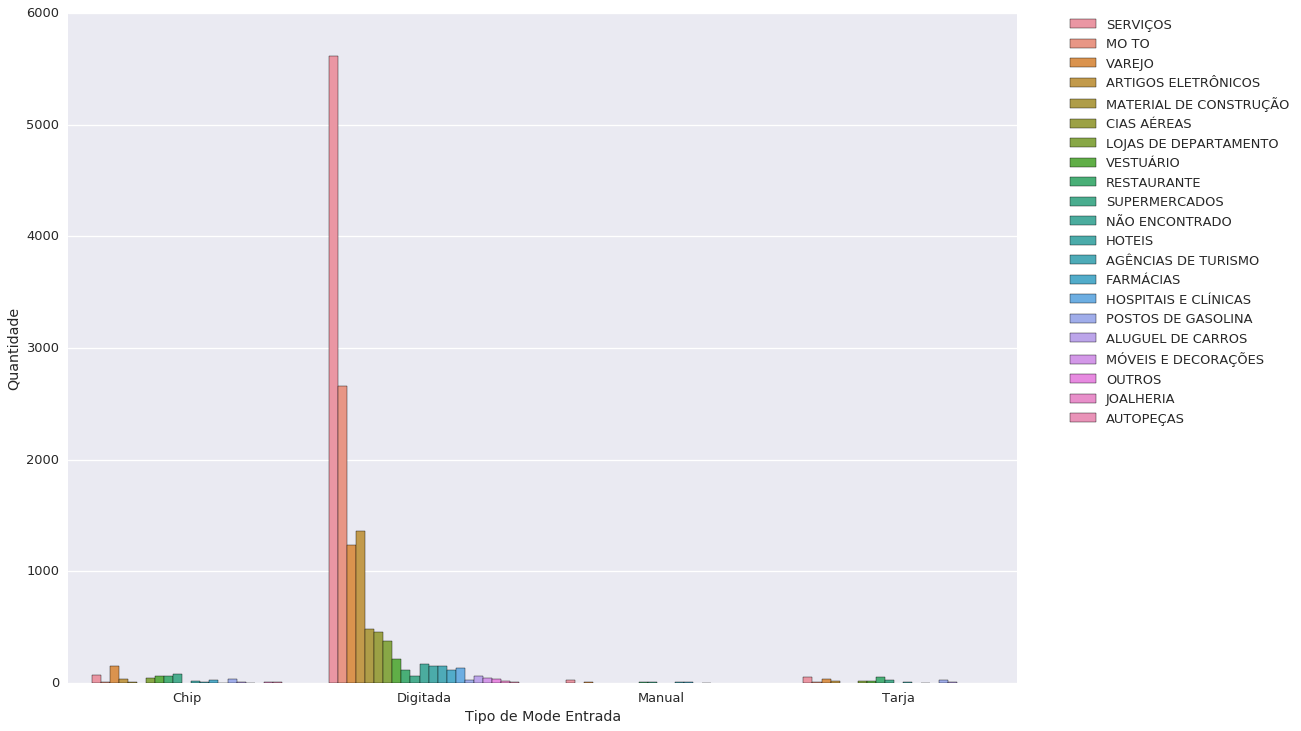

In [14]:
sns.set_context("talk")
plt.figure(figsize=(17, 12))
contestacoesPorRamoEModoEntradaPandas = dfContestacoesModoEntrada.cube("ramoEstabelecimentoNome", "modoEntradaNome").count().orderBy("modoEntradaNome",desc("count")).toPandas()
g = sns.barplot(x="modoEntradaNome", y="count", hue="ramoEstabelecimentoNome", data=contestacoesPorRamoEModoEntradaPandas)
g.set(xlabel='Tipo de Mode Entrada', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Quais são os países que temos mais problemas com o uso presente (Tarja/Chip)?

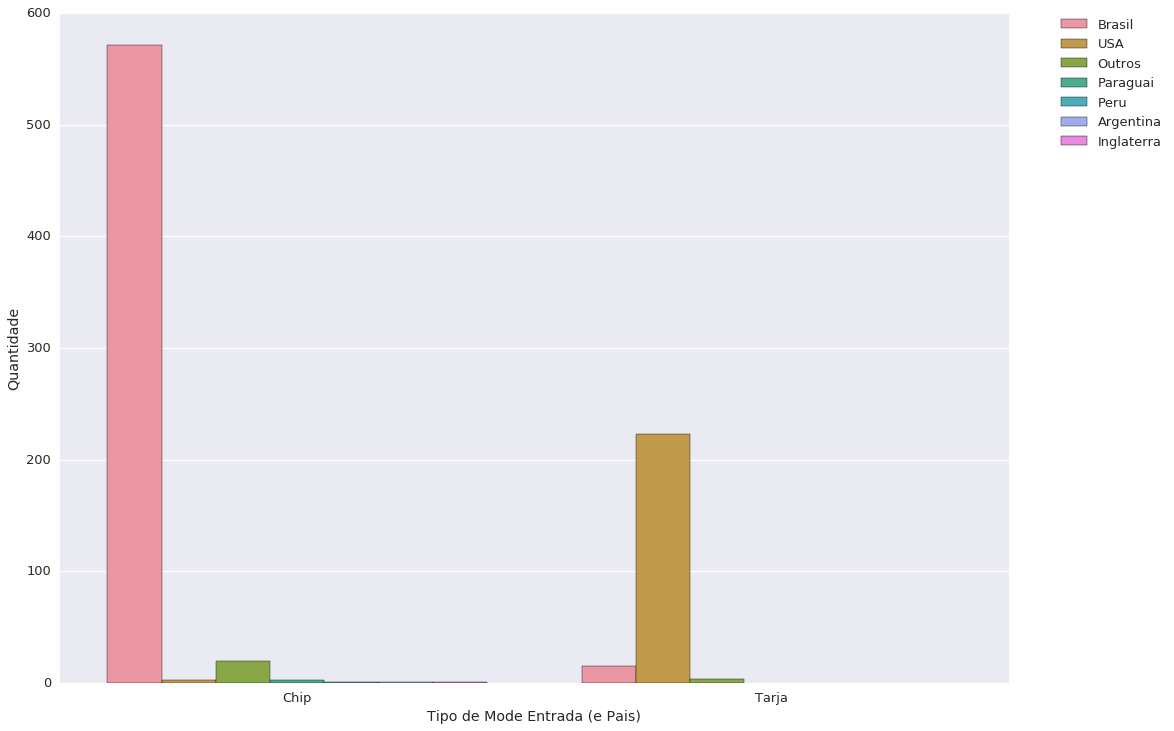

In [15]:
from pyspark.sql.functions import desc
dfContestacoesPorPaisEUso = dfContestacoesModoEntrada.filter("usoPresente = 'Presente'").withColumn('pais',
                                                      when(dfContestacoes.pais == 32,"Argentina").
                                                      when(dfContestacoes.pais == 76,"Brasil").
                                                      when(dfContestacoes.pais == 250,"França").
                                                      when(dfContestacoes.pais == 600,"Paraguai").
                                                      when(dfContestacoes.pais == 604,"Peru").
                                                      when(dfContestacoes.pais == 840,"USA").
                                                      when(dfContestacoes.pais == 826,"Inglaterra").
                                                      otherwise("Outros"))
dfContestacoesPorPaisEUsoPandas = dfContestacoesPorPaisEUso.cube("pais", "modoEntradaNome").count().orderBy(desc("count")).toPandas().head(20)
sns.set_context("talk")
plt.figure(figsize=(17, 12))
g = sns.barplot(x="modoEntradaNome", y="count", hue="pais", data=dfContestacoesPorPaisEUsoPandas)
g.set(xlabel='Tipo de Mode Entrada (e Pais)', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avaliando tendencias de contestações ao longo do tempo

Vamos avaliar a quantidade de contestações ao longo do tempo para identificar tendencias. Vamos considerar a quantidade ao invés do valor pois:
* Valores mudam ao longo do tempo conforme a tendencia inflacionária
* Valores mudam variam ao longo do tempo por conta da oscilação da moeda

Quantidade de contestações ao longo do tempo:

Preparando a data para manipulação:

Contestações ao longo do tempo:

In [16]:
dfContestacoesDataFull = dfContestacoesModoEntrada.withColumn('dataAutorizacao',to_date(dfContestacoesModoEntrada.dataHoraAutorizacao))
#dfCountContestacoesDatapandas = dfContestacoesData.toPandas()

In [17]:
dfCountContestacoesPorDiaFullPandas = dfContestacoesDataFull.groupBy('dataAutorizacao').count().select(col('dataAutorizacao'),col('count').alias('qtde')).toPandas()

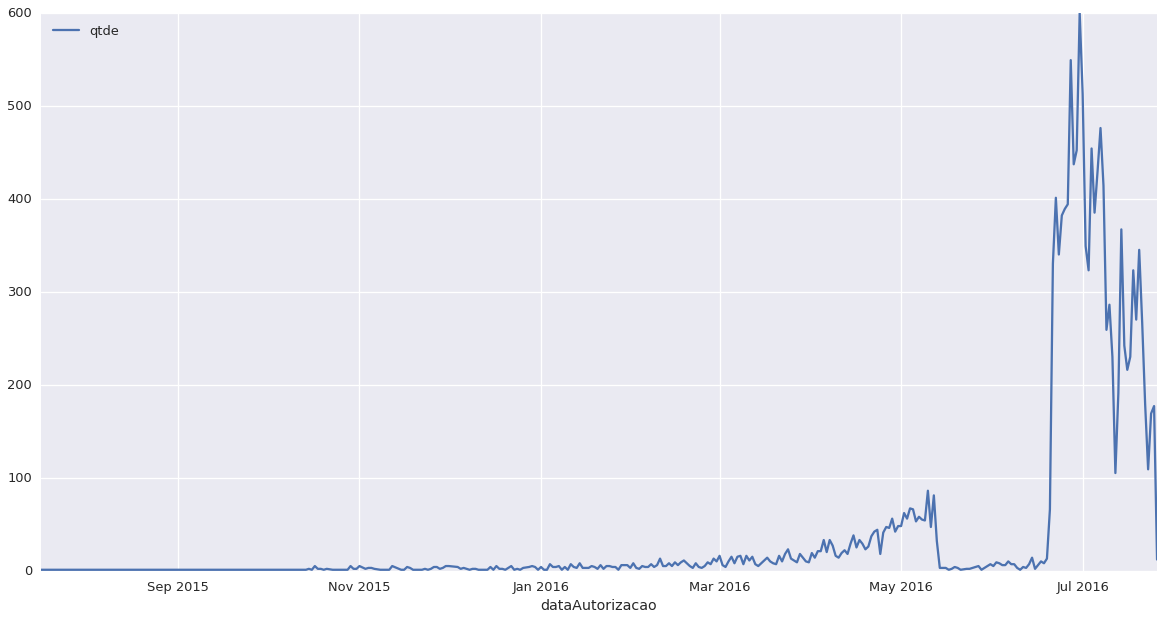

In [18]:
dfCountContestacoesPorDiaFullPandas.sort_values(by='dataAutorizacao').set_index('dataAutorizacao').plot(figsize=(20,10))

# Plota com o std
#sns.plot(data=dfCountContestacoesPorDiaPandas)

Aparentemente, somente temos registros importantes de constestações a partir de meados de 2016

In [32]:
dfContestacoesData = dfContestacoesDataFull.withColumn('ano',year('dataAutorizacao')).filter('ano > 2015').cache()
dfCountContestacoesPorDiaPandas = dfContestacoesData.groupBy('dataAutorizacao').count().select(col('dataAutorizacao'),
                                                                                            col('count').alias('qtde')).toPandas()

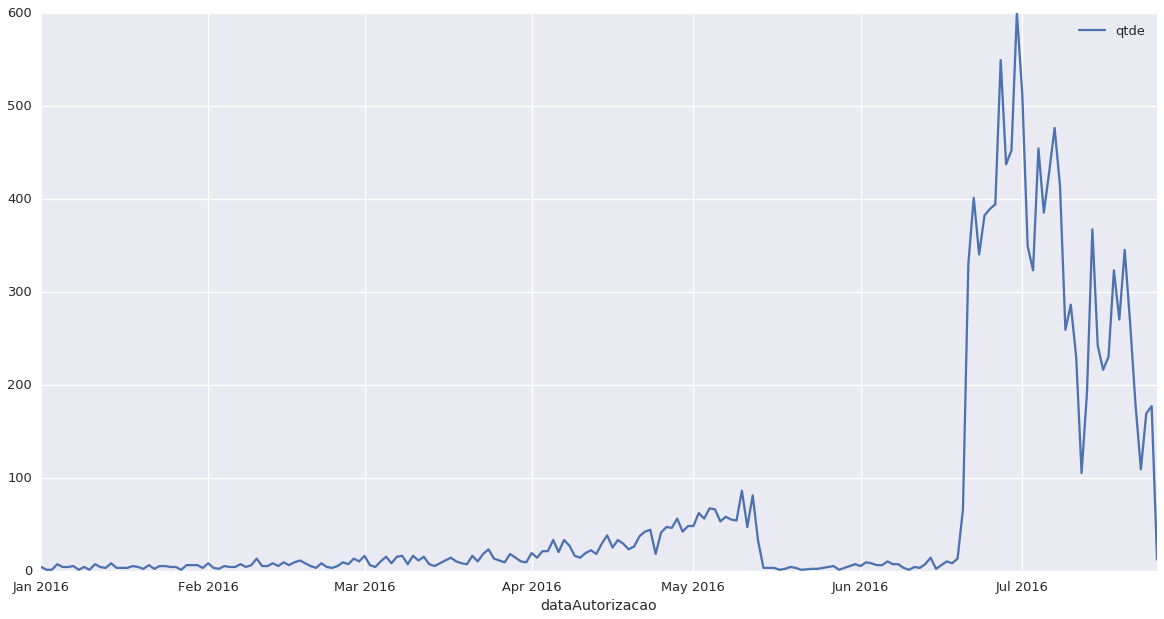

In [33]:
dfCountContestacoesPorDiaPandas.sort_values(by='dataAutorizacao').set_index('dataAutorizacao').plot(figsize=(20,10))

Quantidade de contestações ao longo do tempo por **modo de entrada:**

In [34]:
pandasDFPorModoEntradaEDia = dfContestacoesData.groupBy('dataAutorizacao','modoEntradaNome').count().select(col('dataAutorizacao'),
                                                                                                            col('modoEntradaNome'),col('count').alias('qtde')).toPandas()
#pd.DataFrame(dfCountContestacoesDatapandas[['dataAutorizacao','modoEntradaNome']].groupby(['dataAutorizacao','modoEntradaNome']).size())

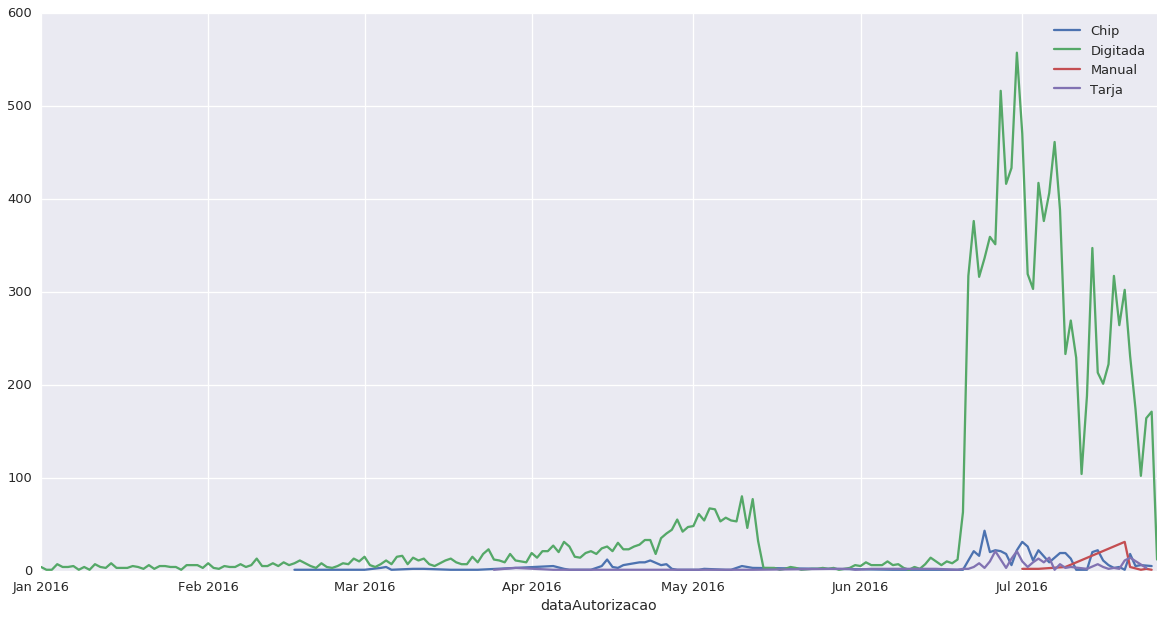

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
labels = []
for key, grp in pandasDFPorModoEntradaEDia.groupby(['modoEntradaNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

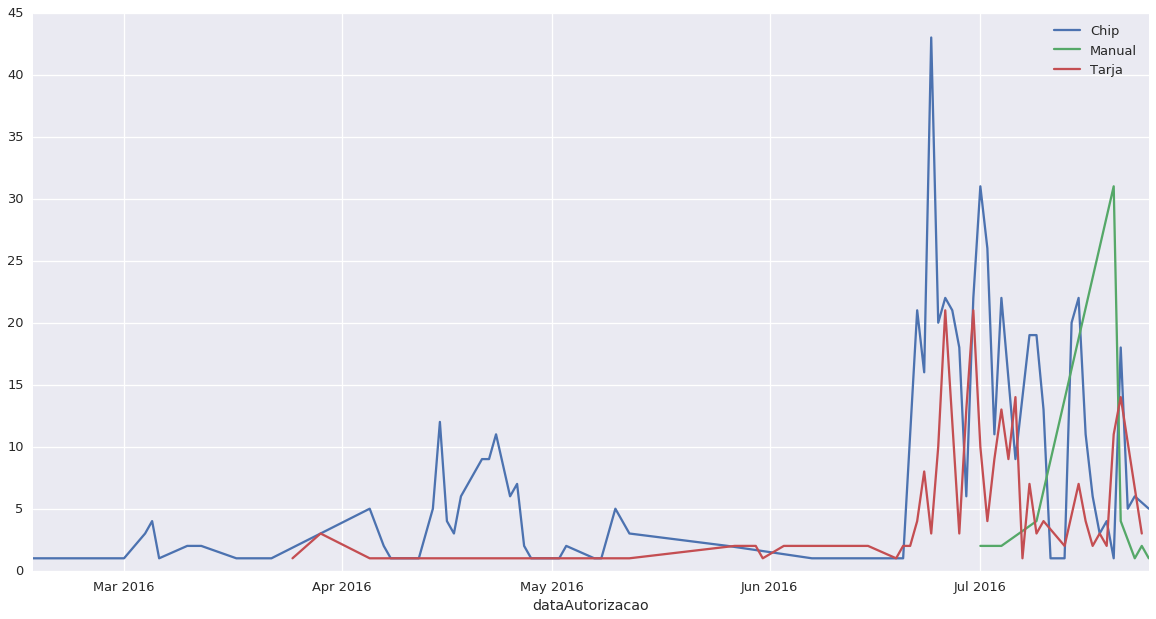

In [36]:
pandasDFPorModoEntradaEDiaSemDigitada = pandasDFPorModoEntradaEDia[pandasDFPorModoEntradaEDia['modoEntradaNome'] != 'Digitada']

fig, ax = plt.subplots(figsize=(20,10))
labels = []
for key, grp in pandasDFPorModoEntradaEDiaSemDigitada.groupby(['modoEntradaNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **modo de entrada - STACKED**:

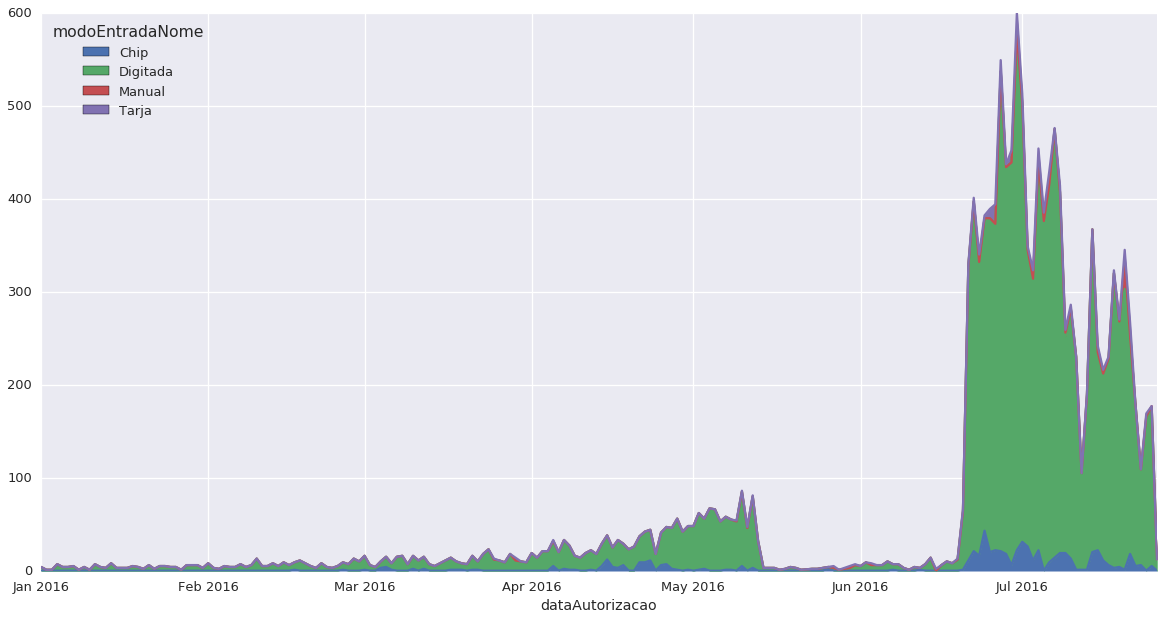

In [37]:
pandasDFPorModoEntradaEDia.groupby(['dataAutorizacao','modoEntradaNome']).qtde.sum().unstack('modoEntradaNome').fillna(0).plot.area(figsize=(20,10))
#pandasContestDiaModoEntrada.set_index('dataAutorizacao').plot()

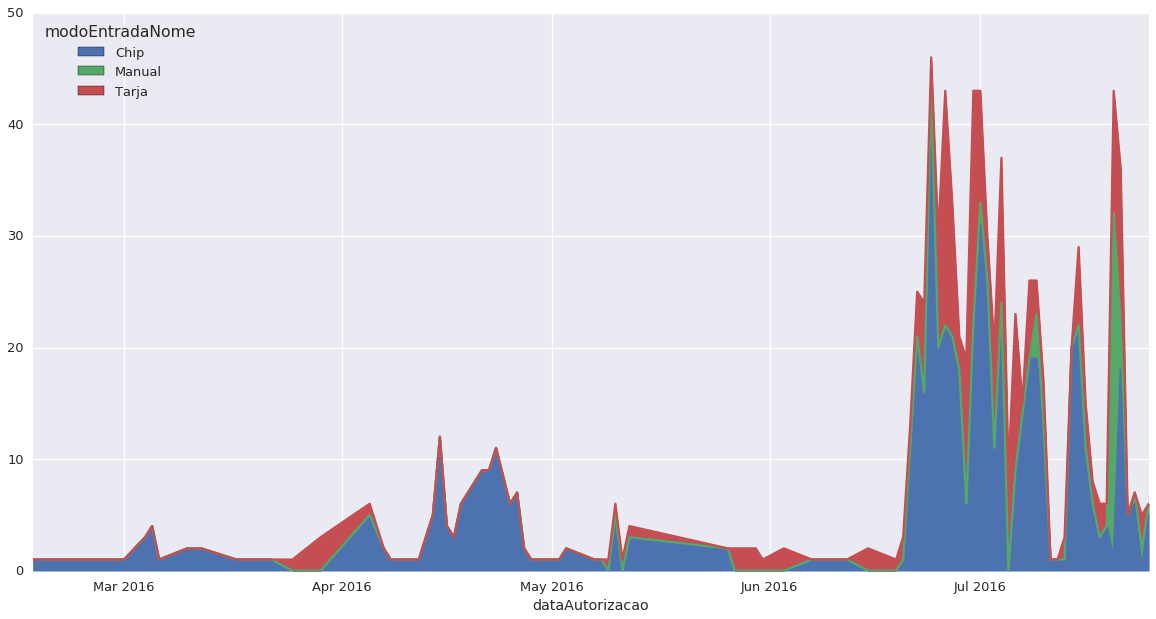

In [38]:
pandasDFPorModoEntradaEDia[pandasDFPorModoEntradaEDia['modoEntradaNome'] != 'Digitada'].groupby(['dataAutorizacao','modoEntradaNome']).qtde.sum().unstack('modoEntradaNome').fillna(0).plot.area(figsize=(20,10))

Quantidade de contestações ao longo do tempo por **modo de entrada - Presente Não Presente:**

Quantidade de contestações ao longo do tempo por **modo de entrada - Presente Não Presente - STACKED**:

Quantidade de contestações ao longo do tempo por **ramo de estabelecimento:**

In [39]:
pandasDFPorRamoEstabelecimentoEDia = dfContestacoesData.groupBy('dataAutorizacao',
                                                                'ramoEstabelecimentoNome').count().select(col('dataAutorizacao'),
                                                                                                          col('ramoEstabelecimentoNome'),
                                                                                                          col('count').alias('qtde')).toPandas()

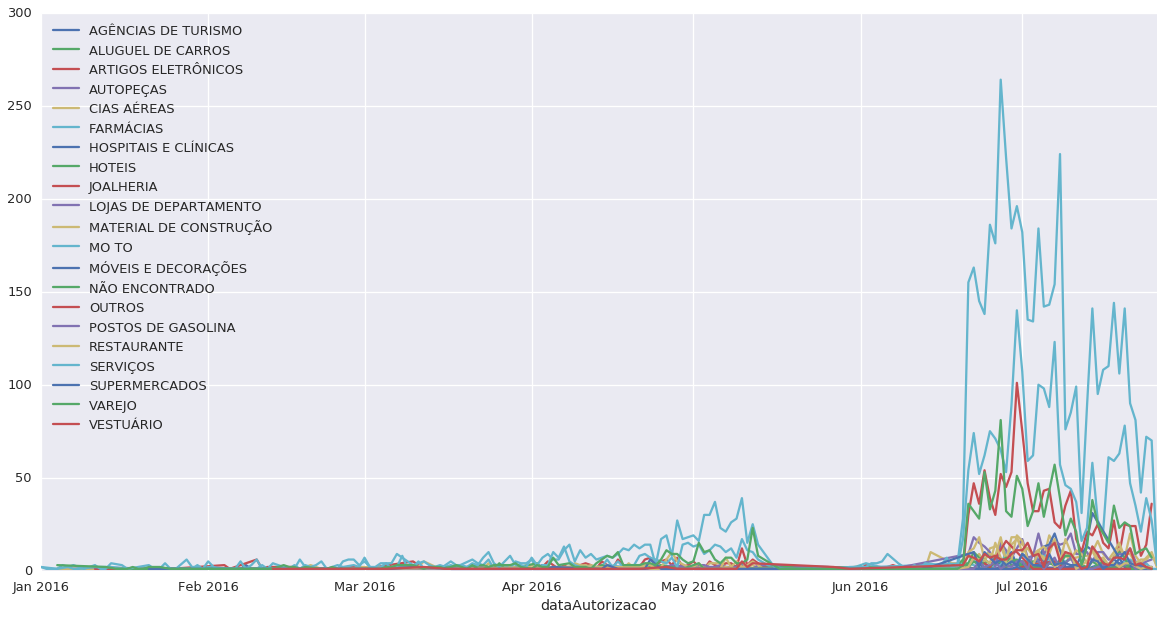

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.set_color_cycle(sns.color_palette("Set2",21))
labels = []
for key, grp in pandasDFPorRamoEstabelecimentoEDia.groupby(['ramoEstabelecimentoNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **ramo de estabelecimento - STACKED:**

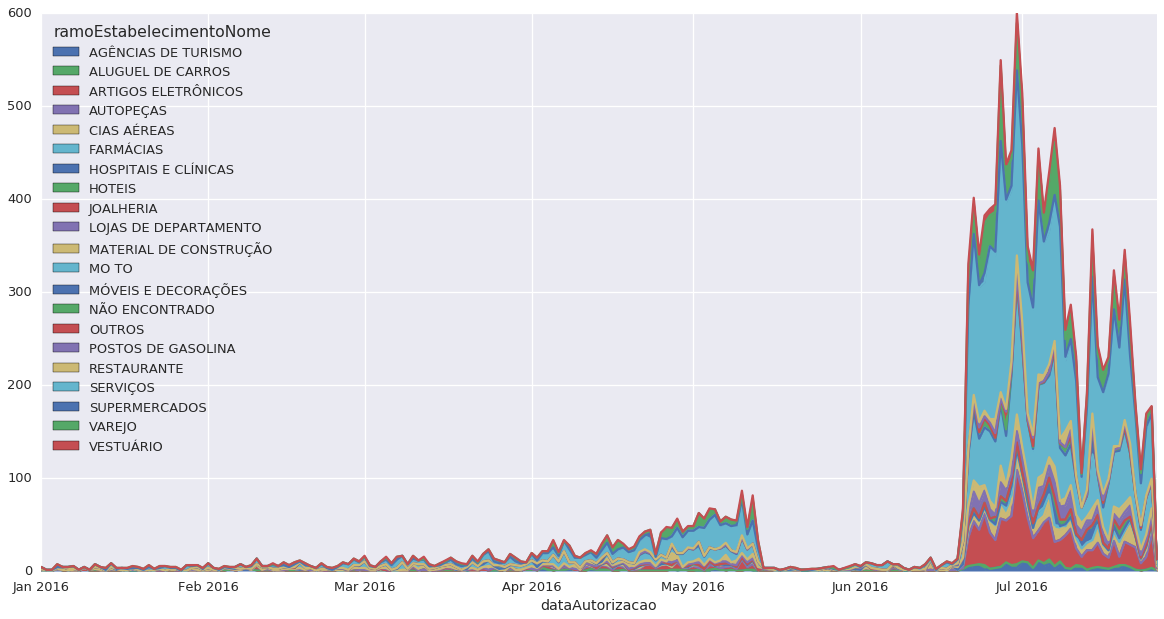

In [41]:
pandasDFPorRamoEstabelecimentoEDia.groupby(['dataAutorizacao',
                                            'ramoEstabelecimentoNome']).qtde.sum().unstack('ramoEstabelecimentoNome').fillna(0).plot.area(figsize=(20,10))


Quantidade de contestações ao longo do tempo por **país:**

In [42]:
dfContestacoesComPais = dfContestacoesData.withColumn('pais',
                                                      when(dfContestacoes.pais == 32,"Argentina").
                                                      when(dfContestacoes.pais == 76,"Brasil").
                                                      when(dfContestacoes.pais == 250,"França").
                                                      when(dfContestacoes.pais == 600,"Paraguai").
                                                      when(dfContestacoes.pais == 604,"Peru").
                                                      when(dfContestacoes.pais == 840,"USA").
                                                      when(dfContestacoes.pais == 826,"Inglaterra").
                                                      otherwise("Outros"))
dfContestacoesPorPais = dfContestacoesComPais.groupBy('dataAutorizacao','pais').count().select(col('dataAutorizacao'),
                                                                    col('pais'),col('count').alias('qtde')).toPandas()

# Sem utilização ainda
dfContestacoesComPaisEPorUsoPresente = dfContestacoesComPais.filter("usoPresente = 'Presente'")

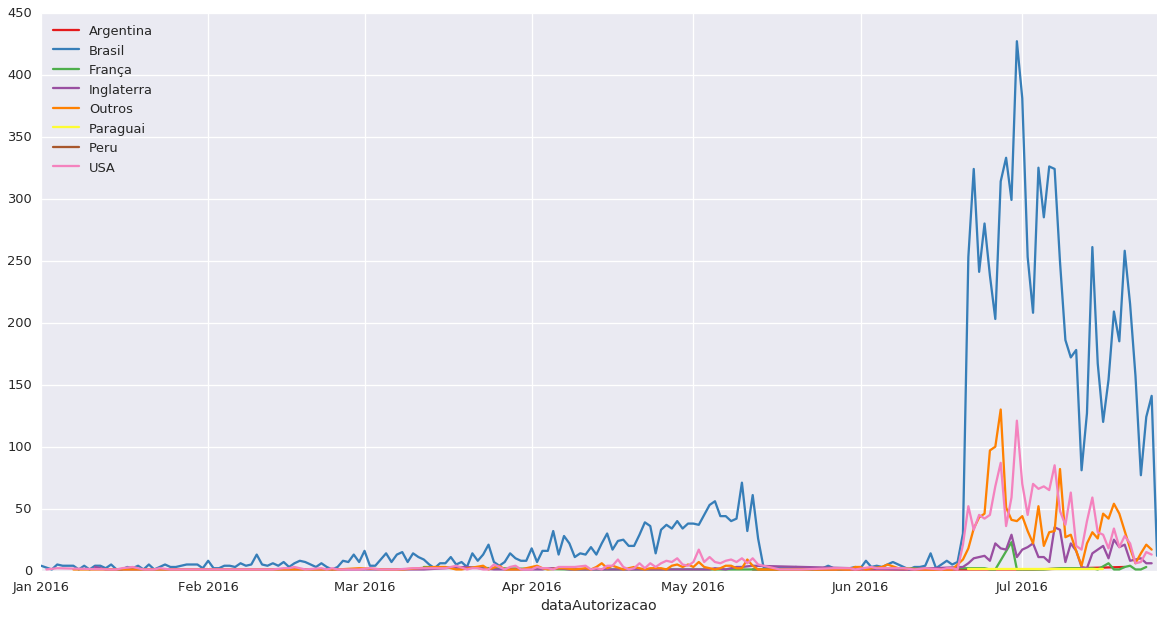

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_color_cycle(sns.color_palette("Set1",21))
labels = []
for key, grp in dfContestacoesPorPais.groupby(['pais']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **país - STACKED:**

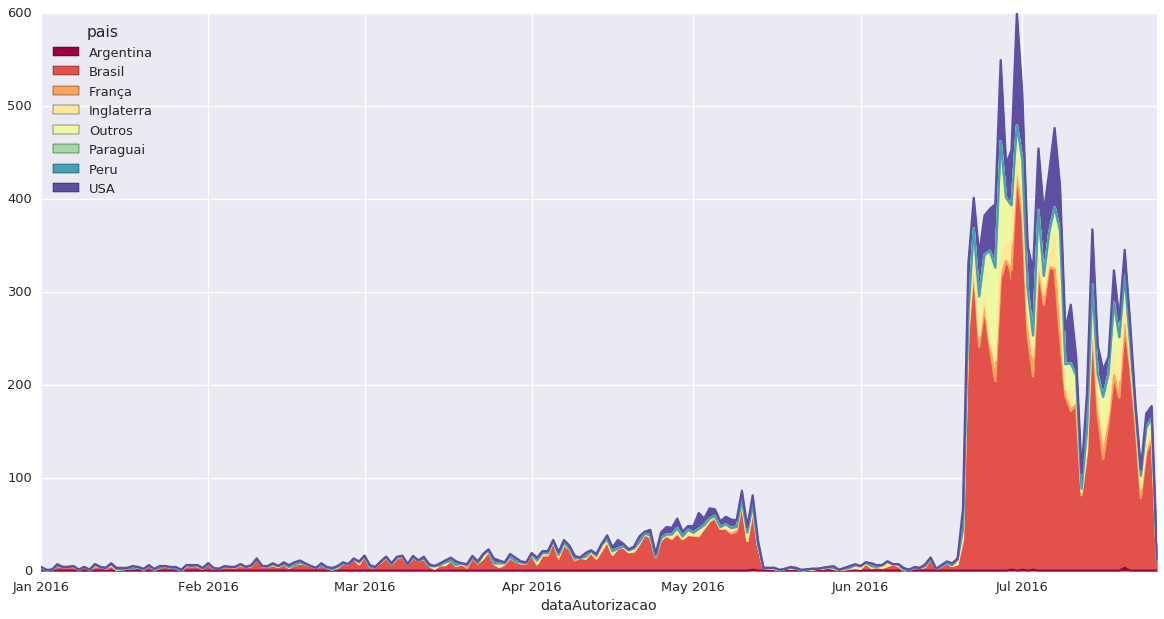

In [44]:
import matplotlib.pyplot as plt
sns.color_palette("Set1",21)
dfContestacoesPorPais.groupby(['dataAutorizacao','pais']).qtde.sum().unstack('pais').fillna(0).plot.area(figsize=(20,10),colormap='Spectral')

## Analisando a variância do valor por mês

## Analisando a variância do valor por dia da semana